# Terrestrial water storage influence on relative sea level

Investigate this question using sle_results.nc file from Thomas F.

Data from Humphrey et al. 2019 are a reconstruction of past natural TWS. They do not include man made TWS.

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import importlib
import sys
sys.path.append('../code')
import SeaLevelContrib as slc

In [ ]:
importlib.reload(slc)

In [ ]:
dir_fpg = '/Users/dewi/Work/Project_SeaLevelBudgets/fp_grace/'
fpg_ds1 = xr.open_dataset(dir_fpg + 'sle_results.nc')
fpg_ds = xr.open_dataset(dir_fpg + 'sle_results.nc', group='TWS/rsl/')
ts_mean = fpg_ds['ts_mean']
ts_mean = xr.DataArray(ts_mean, coords={'time': fpg_ds1.time[:], 'lat': fpg_ds1.lat[:], 'lon': fpg_ds1.lon[:]})
ts_mean.time


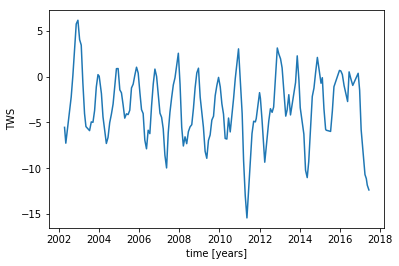

In [25]:
tg_id = [20, 22]
for i in range(len(tg_id)):
    tg_lat, tg_lon =  slc.tg_lat_lon([tg_id[i]])
    TWS = np.array(ts_mean.sel(lon = tg_lon.values , lat = tg_lat.values, method='nearest'))
    if i == 0:
        TWS_tot = TWS.copy()
    else:
        TWS_tot = TWS_tot + TWS
TWS = TWS_tot[:,0,0] / len(tg_id)
TWS = xr.DataArray(TWS, dims=['time'], coords={'time': fpg_ds1.time[:]})
TWS.name = 'TWS'
TWS.plot()


In [64]:
#Export time series to pandas data frame to compute yearly averages
# !!! Strange time stepping in the file, there seem to be some missing data in years 2011->2017
TWS_df = TWS.to_dataframe()
TWS_df['Year_int'] = TWS_df.index.astype(int)
grouped = TWS_df.groupby('Year_int', axis=0)
TWS_df = grouped.mean()
#TWS_df = TWS_df.loc[TWS_df.index <= 2016 && TWS_df.index >= 2003]
TWS_df = TWS_df.loc[2003:2016] # Exclude first and last year
#TWS_df.columns = ['TWS']
TWS_df

,TWS
Year_int,
2003,-2.090401
2004,-3.104785
2005,-1.919226
2006,-3.439528
2007,-3.515167
2008,-3.984507
2009,-4.518726
2010,-2.871942
2011,-7.320096


This TWS term improves the budget of sea level at the Dutch coast during the years 2003-3016. Unfortynately this is very short. Would it be possible to run a sea level equation model using TWS term from Humpfrey et al. 2019?
Is there a difference between global and local TWS term?

In [73]:
dir_tws = '/Users/dewi/Work/Project_SeaLevelBudgets/TWS/04_global_averages_allmodels/monthly/ensemble_means/'
#Choice of files:
# 'GRACE_REC_v03_GSFC_ERA5_monthly_ensemblemean_withoutGreenlandAntarctica.txt'
# 'GRACE_REC_v03_GSFC_GSWP3_monthly_ensemblemean_withoutGreenlandAntarctica.txt'
file_name = 'GRACE_REC_v03_GSFC_GSWP3_monthly_ensemblemean_withoutGreenlandAntarctica.txt'
TWS_glo_df = pd.read_csv(dir_tws + file_name)
TWS_glo_df['Year'] = pd.to_datetime(TWS_glo_df['Time'], format='%Y%m').dt.year
TWS_glo_df = TWS_glo_df.set_index('Year')
del TWS_glo_df['Time']
del TWS_glo_df['TWS_seasonal_cycle_in_Gt']
grouped = TWS_glo_df.groupby('Year', axis=0)
TWS_glo_df = grouped.mean()
TWS_glo_df = - TWS_glo_df / 360 # Convert Gt TWS to mm sea level
TWS_glo_df.columns = ['TWS']
TWS_glo_df

,TWS
Year,
1901,2.904046
1902,3.046868
1903,2.217356
1904,2.142718
1905,3.060549
1906,1.807345
1907,1.309579
1908,1.927280
1909,2.493475


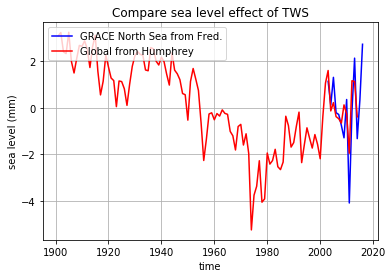

In [88]:
#Plot time series
fig, ax = plt.subplots() #figsize=(12,12)
ax.plot(TWS_df - TWS_df.TWS.mean(axis=0), 'b-', label='GRACE North Sea from Fred.')
ax.plot(TWS_glo_df - TWS_glo_df.TWS.loc[2003:2016].mean(axis=0), 'r-', label='Global from Humphrey')
#ax.set_aspect(1)
plt.xlabel('time')
plt.ylabel('sea level (mm)')
plt.title('Compare sea level effect of TWS')
plt.legend(loc='upper left')
ax.grid(True)

It seems that the global TWS is reasonably correlated with the local but with less variance. It is therefore worth checking what the impact on the budget is.

After checking: Using global terrestrial water storage does not improve the closure of the sea level budget. 

### Files from Thomas. grd format.

In [10]:
thom_dir = '/Users/dewilebars/Projects/SLBudget/data/TWS/Frederikse2016/'
#result_dam_mean.grd   result_hydro_mean.grd
dam_ds = xr.open_dataset(thom_dir + 'result_dam_mean.grd')
grw_ds = xr.open_dataset(thom_dir + 'result_hydro_mean.grd')
dam_ds.RSL #[-1]

<xarray.DataArray 'RSL' (t: 57, y: 360, x: 720)>
[14774400 values with dtype=float32]
Coordinates:
  * t        (t) float32 1958.0 1959.0 1960.0 1961.0 ... 2012.0 2013.0 2014.0
  * y        (y) float32 -89.75 -89.25 -88.75 -88.25 ... 88.25 88.75 89.25 89.75
  * x        (x) float32 0.25 0.75 1.25 1.75 ... 358.25 358.75 359.25 359.75

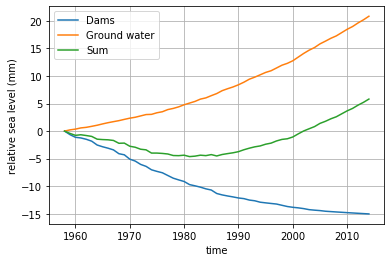

In [18]:
fig, ax = plt.subplots()
ax.plot(dam_ds.t,dam_ds.RSL[:,0,0]*1000, label='Dams')
ax.plot(dam_ds.t,grw_ds.RSL[:,0,0]*1000, label='Ground water')
ax.plot(dam_ds.t,(dam_ds.RSL[:,0,0]+grw_ds.RSL[:,0,0])*1000, label='Sum')

plt.xlabel('time')
plt.ylabel('relative sea level (mm)')
plt.legend(loc='upper left')
ax.grid(True)

#plt.savefig('../Figures/LandWaterStorage_1958_2014.pdf')